In [1]:
import platform
platform.python_version()

'3.11.14'

In [2]:
import os,csv,re
import pandas as pd
import numpy as np

import math
from scipy.sparse import issparse
import random 
import warnings
warnings.filterwarnings("ignore")

import matplotlib.colors as clr
import matplotlib.pyplot as plt

import scanpy as sc

# opencv for reading in images only
# import cv2

import time

In [3]:
seeds = [0]
random.seed(seeds[0])
np.random.seed(seeds[0])

In [4]:
print(f" numpy: {np.__version__}, pandas: {pd.__version__} scanpy: {sc.__version__}")
# print(f"cv2: {cv2.__version__}")

def print_adata_minmax(adata):
    print(f"minimum value: {np.amax(adata.X):0.3f}, maximum value: {np.amin(adata.X):0.3f}\n")

 numpy: 2.3.4, pandas: 2.3.3 scanpy: 1.11.5


In [5]:
from scanpy import read_10x_h5

samples = [
    "151673","151674","151675","151676",
]

num_clusters_list = [7,7,7,7] # target cluster number

In [6]:
from sklearn.metrics.cluster import adjusted_rand_score

def calc_ari(adata, manual:str, predicted:str):
    return adjusted_rand_score(
        adata.obs[manual].cat.codes, 
        adata.obs[predicted].cat.codes
    )

In [7]:
#Set colors used
plot_color = [
    "#F56867",
    "#FEB915",
    "#C798EE",
    "#59BE86",
    "#7495D3",
    "#D1D1D1",
    "#6D1A9C",
    "#15821E",
    "#3A84E6",
    "#997273",
    "#787878",
    "#DB4C6C",
    "#9E7A7A",
    "#554236",
    "#AF5F3C",
    "#93796C",
    "#F9BD3F",
    "#DAB370",
    "#877F6C",
    "#268785"
]

## Preprocess data

In [11]:
from banksy_utils import filter_utils


def normalization_and_hvg_cal (sample):
    
    print('######## Analysing ' + sample + '########')

    ### data loading ###
    data_path = os.path.join("data","DLPFC", sample)
    expr_path = os.path.join(data_path, f"{sample}_raw_feature_bc_matrix.h5")
    spatial_path = os.path.join(data_path, f"tissue_positions_list.txt")
    manual_path = os.path.join("data","DLPFC","barcode_level_layer_map.tsv")

    # load data
    adata = read_10x_h5(expr_path)
    spatial = pd.read_csv(spatial_path, sep=",", header=None,
                          na_filter=False, index_col=0)

    # load manual annotations
    manual = pd.read_csv(manual_path, sep="\t", header=None,
                         names=["sample_no", "layer"],
                         na_filter=False, index_col=0)
    manual = manual.loc[manual["sample_no"] == int(sample), :]

    adata.var_names_make_unique(join = ".")

    # include coordinates information
    adata.obs["x1"] = spatial[1]
    adata.obs["x_array"] = spatial[2]
    adata.obs["y_array"] = spatial[3]
    adata.obs["x_pixel"] = spatial[4]
    adata.obs["y_pixel"] = spatial[5]

    # include manual annotation
    adata.obs["manual_annotations"] = manual["layer"]
    adata.obs["manual_annotations"].fillna(value="other", inplace=True)

    adata.obs["manual_annotations"] = adata.obs["manual_annotations"].astype("category")

    # Select captured samples
    adata.var_names = [i.upper() for i in list(adata.var_names)]
    adata.var["genename"] = adata.var.index.astype("str")

    ### Data PRocessing ###
    
    # remove unannotated spots
    adata = adata[adata.obs["manual_annotations"] != "other", :]
    
    # Normalize data
    adata = filter_utils.normalize_total(adata,)
    # adata = filter_utils.normalize_total(adata, target_sum=5000)

    return adata

### read r derived hvgs 

In [12]:
r_hvg = pd.read_csv(os.path.join("data","DLPFC", "simple_concat", "output_hvg_median_library.csv")) #HVGs Union of all 4 samples 
r_hvg[r_hvg.columns[0]] = r_hvg[r_hvg.columns[0]].str.upper()
r_hvg = r_hvg.astype(str)

In [13]:
# Load sample
adata_list = {} # store multiple samples in dictionary

for n, sample in enumerate(samples):
    adata_list[sample] = normalization_and_hvg_cal(sample)
    # subset adata object to union of all r derived hvgs
    adata_list[sample] = adata_list[sample][:, r_hvg['hvgs']]

######## Analysing 151673########
--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 610.0, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 298.43701171875, Min: 0.0

######## Analysing 151674########
--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 511.0, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 292.06341552734375, Min: 0.0

######## Analysing 151675########
--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 417.0, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 229.22715759277344, Min: 0.0

######## Analysing 151676########
--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 413.0, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 271.3492126464844, Min: 0.0



## Running BANKSY
Finally we run BANKSY using the following (default) parameters for `cell-typing`:
- $k_{geom} = 6 (no AGF)$
-  $\lambda = 0.2$
- m = 1 (first order azimuthal transform)
</br>

From, the BANKSY embeddings, we then
- Run PCA with 20 PCs
- Perform Leiden clustering with a resolution parameter of 1.0
<br>


Median distance to closest cell = 137.00364958642524

---- Ran median_dist_to_nearest_neighbour in 0.00 s ----

---- Ran generate_spatial_distance_graph in 0.01 s ----

---- Ran row_normalize in 0.00 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.04 s ----

----- Plotting Weights Graph -----
Maximum weight: 0.3467140944738107

---- Ran plot_graph_weights in 0.10 s ----

Runtime Nov-12-2025-14-32

5029 genes to be analysed:
Gene List:
Index(['NPY', 'PLP1', 'IGKC', 'HBB', 'HBA2', 'MBP', 'SST', 'IGHG3', 'CNP',
       'CRYAB',
       ...
       'TFPI', 'NRM', 'LAT2', 'WNT2', 'AC003102.1', 'CARD10', 'ANKRD44',
       'SELENOI', 'MFSD8', 'PNMA8B'],
      dtype='object', length=5029)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21666 stored elements and shape (3611, 3611)>}}

Nbr matrix | Mean: 0.21 | Std: 0.96
Size of Nbr | Shape: (3611, 5029)
Top 3 entri

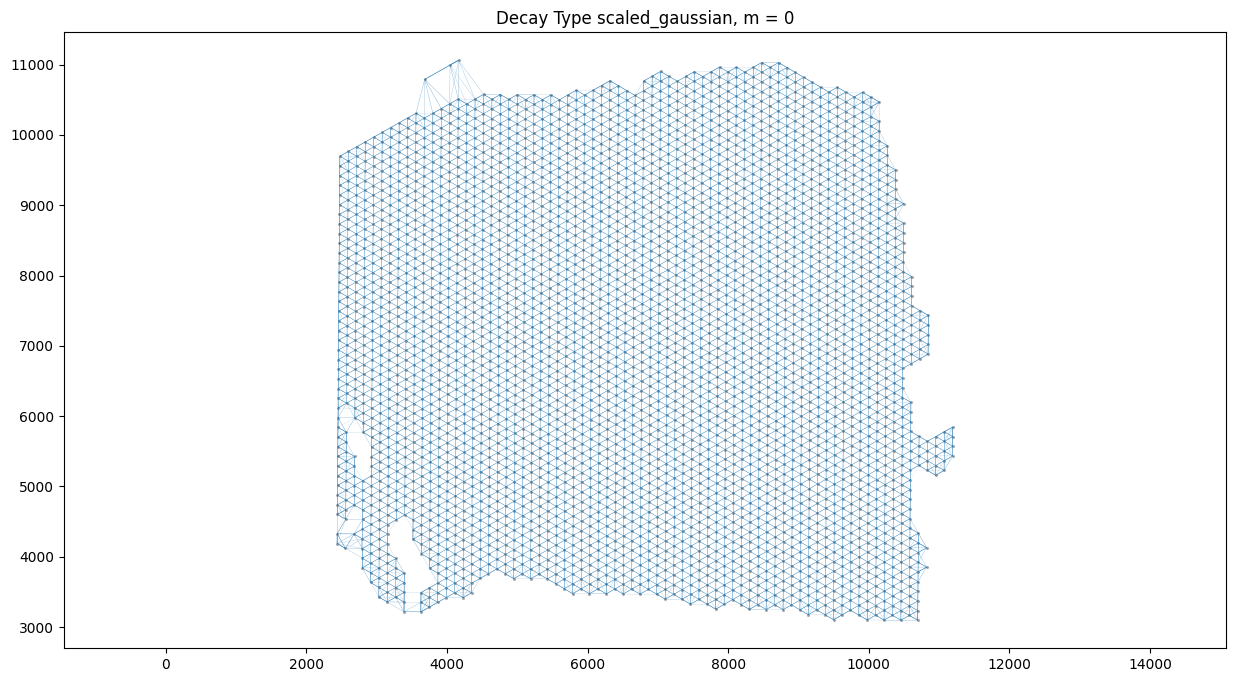

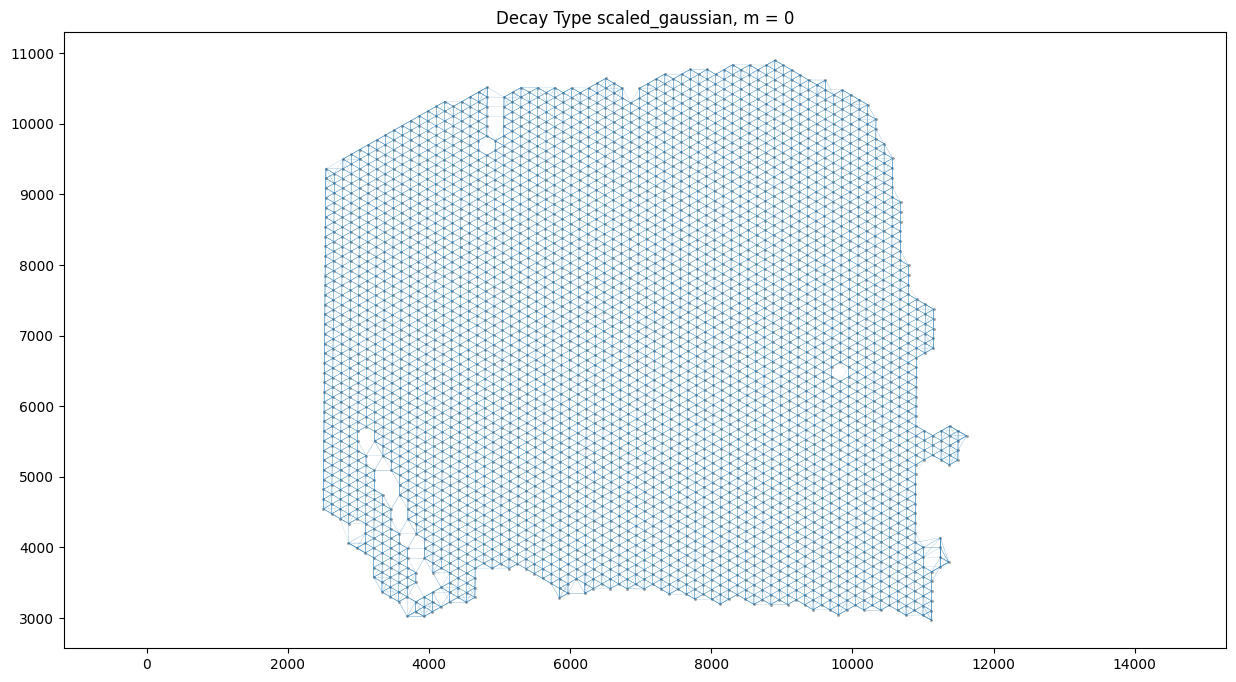

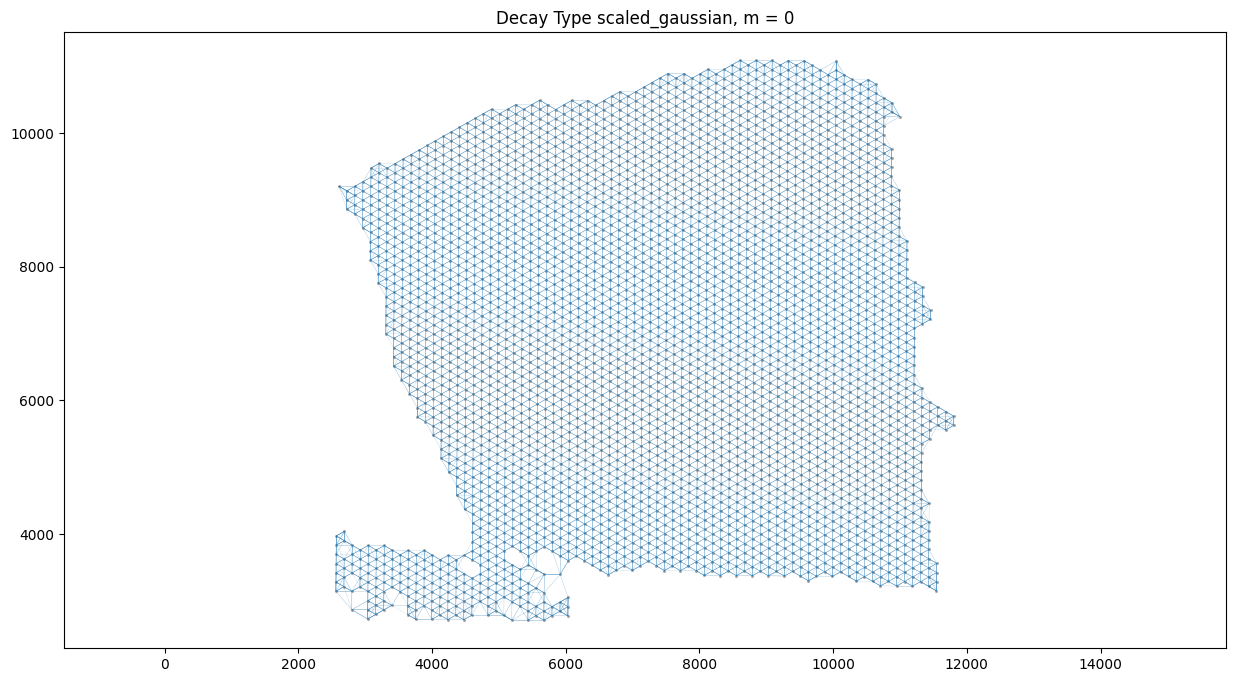

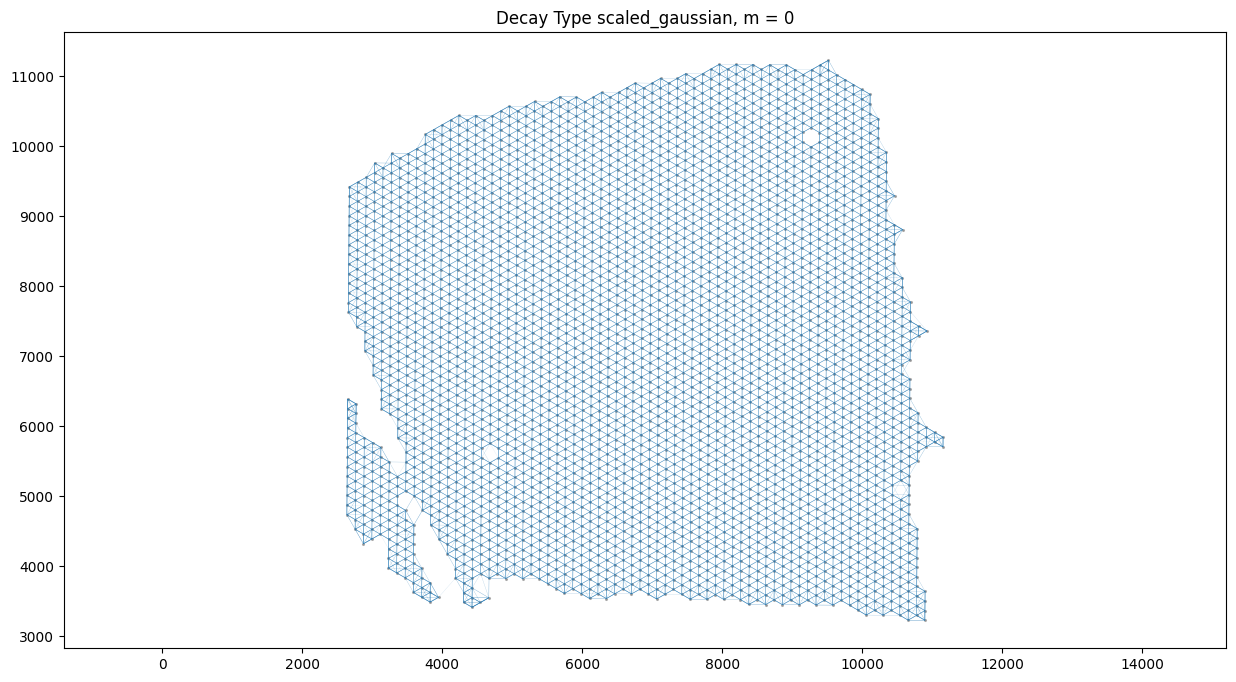

In [14]:
## banksy parameters ##
from banksy.initialize_banksy import initialize_banksy
banksy_dict = {}
coord_keys = ('x_pixel', 'y_pixel', 'coord_xy')
nbr_weight_decay = 'scaled_gaussian'
k_geom = 6
x_coord, y_coord, xy_coord = coord_keys[0], coord_keys[1], coord_keys[2]


from banksy.main import concatenate_all
from banksy.embed_banksy import generate_banksy_matrix
resolutions = [0.60] # clustering resolution for UMAP
pca_dims = [20] # Dimensionality in which PCA reduces to
lambda_list = [0.2] # list of lambda parameters
m = 0
from banksy_utils.umap_pca import pca_umap
from banksy.cluster_methods import run_Leiden_partition
results_df = {}
max_num_labels = {}
from banksy.plot_banksy import plot_results
c_map =  'tab20' # specify color map


### run banksy ###

for sample in samples:
    # Include spatial coordinates information
    raw_y, raw_x = adata_list[sample].obs[y_coord], adata_list[sample].obs[x_coord]
    adata_list[sample].obsm[xy_coord] = np.vstack((adata_list[sample].obs[x_coord].values, adata_list[sample].obs[y_coord].values)).T

    banksy_dict[sample] = initialize_banksy(adata_list[sample],
                                            coord_keys,
                                            k_geom,
                                            nbr_weight_decay=nbr_weight_decay,
                                            max_m=m,
                                            plt_edge_hist= False,
                                            plt_nbr_weights= True,
                                            plt_agf_angles=False,
                                            plt_theta=False
                                            )
    banksy_dict[sample], banksy_matrix = generate_banksy_matrix(adata_list[sample],
                                                                banksy_dict[sample],
                                                                lambda_list,
                                                                max_m=m)
    banksy_dict[sample]["nonspatial"] = {
        # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
        0.0: {"adata": concatenate_all([adata_list[sample].X], 0, adata=adata_list[sample]), }
    }
    print(banksy_dict[sample]['nonspatial'][0.0]['adata'])


### Simple concatenation of different samples

In [15]:
import anndata as ad
np.random.seed(seeds[0])

banksy_dict_concat = {}
df_obs = pd.DataFrame()
df_var = pd.DataFrame()

for sample in samples:
        for nbr_wd in banksy_dict[sample]:
            if sample == samples[0]:
                banksy_dict_concat[nbr_wd] ={}
        
            for lambda_param in banksy_dict[sample][nbr_wd]:
            
                if isinstance(lambda_param, str):
                    continue # skip weights matrices

                if sample == samples[0]:
                    banksy_dict_concat[nbr_wd][lambda_param] ={}
                
                # Retrieve anndata object
                # -----------------------
            
                adata_temp = banksy_dict[sample][nbr_wd][lambda_param]["adata"]
                
                #Concatenate by genes 
                adata_temp.obs['sample'] = sample
                adata_temp.obs_names = [f"{cell}{sample}" for cell in adata_temp.obs_names]

                if sample == samples[0]:
                    
                    banksy_dict_concat[nbr_wd][lambda_param]["adata"] = adata_temp
                    
                else:
                    
                    df_obs = pd.concat([banksy_dict_concat[nbr_wd][lambda_param]['adata'].obs, adata_temp.obs]) 
                    
                    banksy_dict_concat[nbr_wd][lambda_param]['adata'] = ad.concat([banksy_dict_concat[nbr_wd][lambda_param]['adata'] , adata_temp], 
                                                                                  label="sample",  join="outer")
                    

                    banksy_dict_concat[nbr_wd][lambda_param]['adata'].obs = df_obs

In [16]:
banksy_dict_concat

{'scaled_gaussian': {0.2: {'adata': AnnData object with n_obs × n_vars = 14243 × 10058
       obs: 'x1', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'manual_annotations', 'sample'}},
 'nonspatial': {0.0: {'adata': AnnData object with n_obs × n_vars = 14243 × 5029
       obs: 'x1', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'manual_annotations', 'sample'}}}

### Run PCA and UMAP

Current decay types: ['scaled_gaussian', 'nonspatial']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 20
Original shape of matrix: (14243, 10058)
Reduced shape of matrix: (14243, 20)
------------------------------------------------------------
min_value = -34.27233733057722, mean = 2.514312566334975e-17, max = 74.77143690481891

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_20_umap"]
UMAP embedding
------------------------------------------------------------
shape: (14243, 2)


AxisArrays with keys: reduced_pc_20, reduced_pc_20_umap

Reducing dims of dataset in (Index = nonspatial, lambda = 0.0)

Setting the total number of PC = 20
Original shape of matrix: (14243, 5029)
Reduced shape of matrix: (14243, 20)
------------------------------------------------------------
min_value = -61.40793786127015, mean = 3.691649402952146e-18, max = 91.02592814251484

Conducting UMAP and adding embeddings to adata.obsm["reduced_

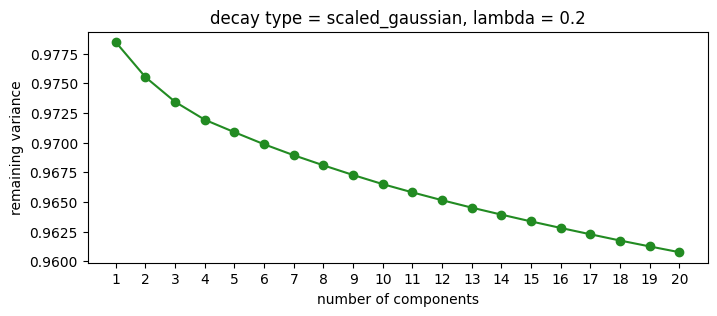

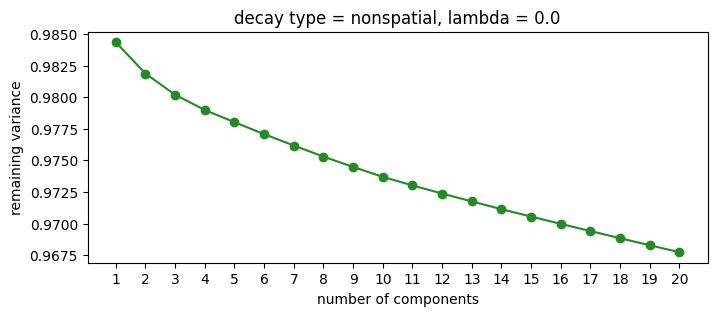

In [17]:
pca_umap(banksy_dict_concat,
         pca_dims=pca_dims,
         add_umap=True
        )

### Run BANKSY clustering

In [18]:
from banksy.cluster_methods import run_Leiden_partition

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict_concat,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = 1234,
    match_labels = True,
)

Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.2
reduced_pc_20 

reduced_pc_20_umap 

PCA dims to analyse: [20]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.2, PCA dimensions = 20)


Nearest-neighbour weighted graph (dtype: float64, shape: (14243, 14243)) has 712150 nonzero entries.
---- Ran find_nn in 1.83 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (14243, 14243)) has 712150 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 12633261 to 710946.


Shared nearest-neighbour (connections only) graph (dtype: int16, shape: (14243, 14243)) has 683775 nonzero entries.

Shared nearest-neighbour (number of shared neighbours as weights) graph (dtype: int16, shape: (14243, 14243)) has 683775 nonzero entries.

sNN graph data:
[24 19 10 ...  7  6  6]

---- Ran shared_nn in 0.45 s ----


-- Multiplying sNN connectivity by weights --


sh

,decay,lambda_param,num_pcs,resolution,num_labels,labels,adata,relabeled
nonspatial_pc20_nc0.00_r0.60,nonspatial,0.0,20,0.6,7,"Label object:\nNumber of labels: 7, number of ...",[[[View of AnnData object with n_obs × n_vars ...,"Label object:\nNumber of labels: 7, number of ..."
scaled_gaussian_pc20_nc0.20_r0.60,scaled_gaussian,0.2,20,0.6,7,"Label object:\nNumber of labels: 7, number of ...",[[[View of AnnData object with n_obs × n_vars ...,"Label object:\nNumber of labels: 7, number of ..."


### Compute ARI to given labels

In [19]:
ari = []
num_clus = []
sample_series = []
index_series = []

for counter, sample in enumerate(samples):
    for params_name in results_df.index:
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()

        
        # If label information is not stored in anndata object 
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]

        ari.append(calc_ari(adata_ari_temp, "manual_annotations", 'labels_' + params_name))
        num_clus.append(results_df.loc[params_name, "num_labels"])
        sample_series.append(sample)
        index_series.append(params_name)

ari_df = pd.DataFrame(ari)
ari_df['num_labels'] = num_clus
ari_df['sample'] = sample_series
ari_df['df_index'] = index_series

### Identify banksy output matching target num_labels

In [20]:
for i, sample in enumerate(samples):
    tar_clus = num_clusters_list[i]
    print(ari_df[(ari_df['num_labels']==tar_clus) & (ari_df['sample'] == sample) & (ari_df['df_index'].str.contains('scaled_gaussian_'))])
    print(np.median(ari_df[0][(ari_df['num_labels']==tar_clus) & (ari_df['sample'] == sample) & (ari_df['df_index'].str.contains('scaled_gaussian_'))]))

          0  num_labels  sample                           df_index
1  0.548115           7  151673  scaled_gaussian_pc20_nc0.20_r0.60
0.5481147678358952
          0  num_labels  sample                           df_index
3  0.640717           7  151674  scaled_gaussian_pc20_nc0.20_r0.60
0.6407166840476829
          0  num_labels  sample                           df_index
5  0.610988           7  151675  scaled_gaussian_pc20_nc0.20_r0.60
0.6109875483625246
          0  num_labels  sample                           df_index
7  0.565272           7  151676  scaled_gaussian_pc20_nc0.20_r0.60
0.5652715946768416


#### Plot banksy results

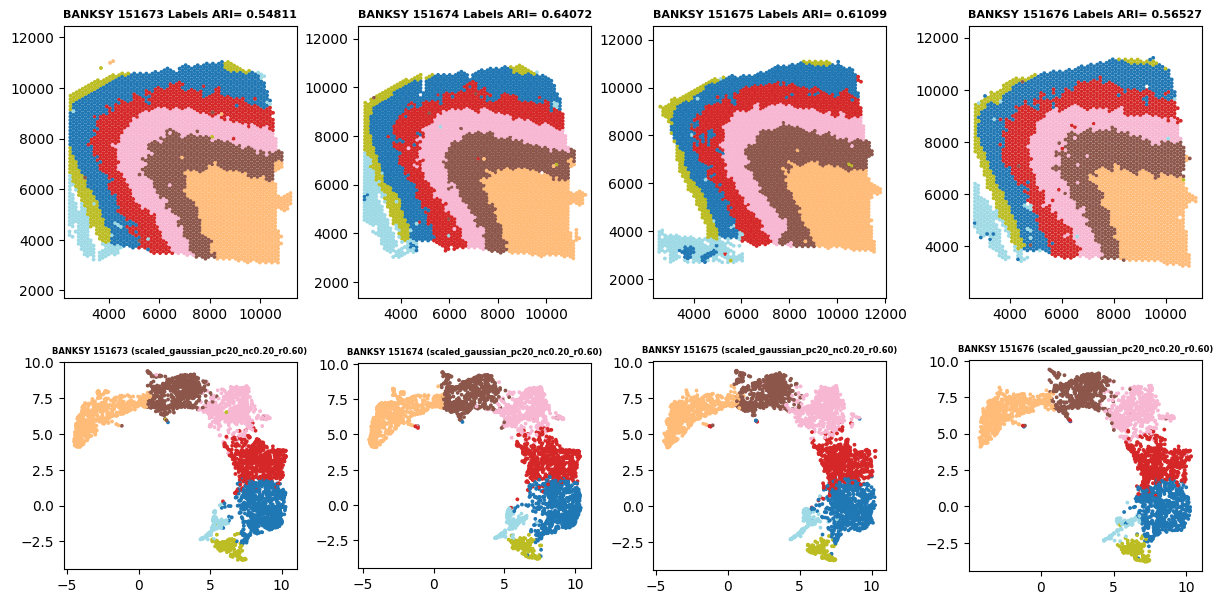

In [21]:
target_params = ['scaled_gaussian_pc20_nc0.20_r0.60']

fig  = plt.figure(figsize=(12, 6) , constrained_layout=True)
grid = fig.add_gridspec(ncols=4, nrows=2)

for counter, sample in enumerate(samples):
    for params_name in target_params:
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()

        
        # If label information is not stored in anndata object 
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
        print_ari = ari_df[(ari_df['sample'] == sample) & (ari_df['df_index'].str.contains(params_name))][0].values[0]
        
        ## plot spatial location
        ax_locs1 = fig.add_subplot(grid[0, counter])
        weights_graph =  banksy_dict[sample]['scaled_gaussian']['weights'][0]
        scatterplot = ax_locs1.scatter(adata_ari_temp.obs[coord_keys[0]],
                                       adata_ari_temp.obs[coord_keys[1]],
                                       c=adata_ari_temp.obs['labels_' + params_name],
                                       cmap=c_map,
                                       vmin=0, vmax=max_num_labels - 1,
                                       s=3, alpha=1.0)
        ax_locs1.set_aspect('equal', 'datalim')
        ax_locs1.set_title(f'BANKSY {sample} Labels ARI= {print_ari:.5f}', fontsize=8, fontweight="bold", )
        
        # plot refined UMAP
        ax_locs2 = fig.add_subplot(grid[1, counter])
        scatterplot = ax_locs2.scatter(adata_ari_temp.obsm['reduced_pc_20_umap'][:,0],
                                       adata_ari_temp.obsm['reduced_pc_20_umap'][:,1],
                                       c=adata_ari_temp.obs['labels_' + params_name],
                                       cmap=c_map,
                                       s=3, alpha=1.0)
        ax_locs2.set_aspect('equal')
        ax_locs2.set_title(f'BANKSY {sample} ({params_name})', fontsize=6, fontweight="bold", )

# Refine label clusters


Number of nodes swapped 138 | ratio: 0.038
Total Entropy: 0.19

Number of nodes swapped 154 | ratio: 0.042
Total Entropy: 0.2

Number of nodes swapped 134 | ratio: 0.038
Total Entropy: 0.19

Number of nodes swapped 160 | ratio: 0.047
Total Entropy: 0.21


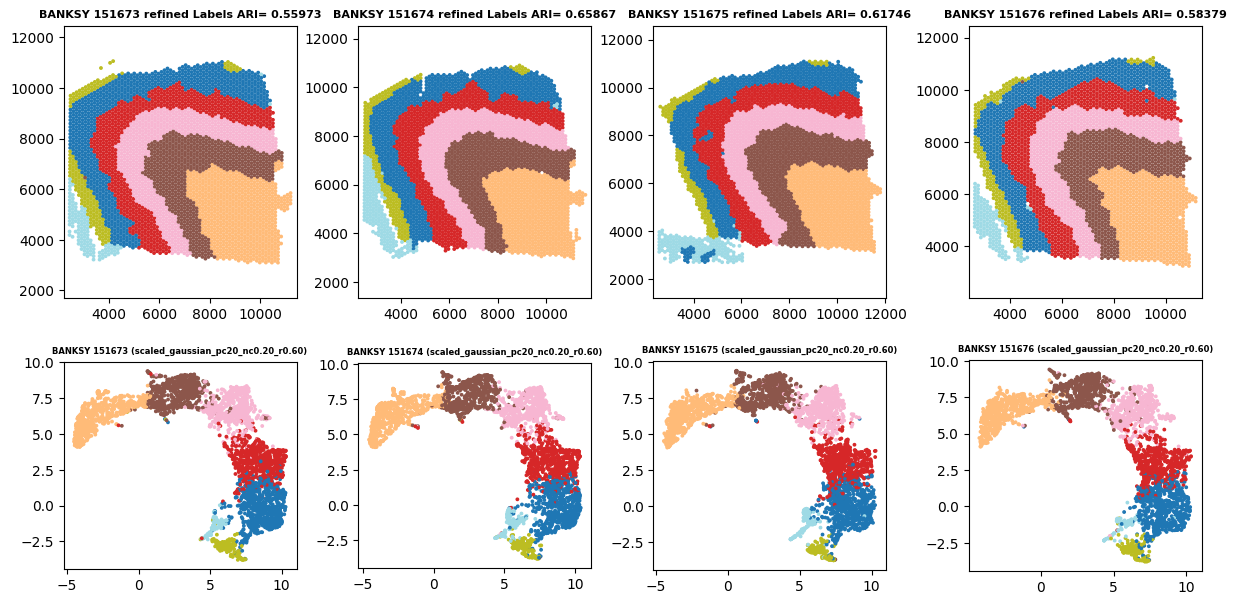

In [22]:
from banksy_utils.refine_clusters import refine_once

target_params = ['scaled_gaussian_pc20_nc0.20_r0.60']
fig  = plt.figure(figsize=(12, 6) , constrained_layout=True)
grid = fig.add_gridspec(ncols=4, nrows=2)

for counter, sample in enumerate(samples):
    for params_name in target_params:
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()

        # If label information is not stored in anndata object
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)

        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]

        ### refine labeling results
        adata_ari_temp.obsm['coord_xy'] = adata_list[sample].obsm['coord_xy']
        refine_label, refine_ari, total_entropy = refine_once(adata_ari_temp,
                                      raw_labels = adata_ari_temp.obs['labels_' + params_name],
                                      truth_labels = adata_ari_temp.obs['manual_annotations'].values,
                                      coord_keys = coord_keys,
                                      num_neigh = k_geom)

        # plot refined spatial plot
        ax_locs1 = fig.add_subplot(grid[0, counter])
        scatterplot = ax_locs1.scatter(adata_ari_temp.obs[coord_keys[0]],
                                      adata_ari_temp.obs[coord_keys[1]],
                                      c=refine_label,
                                      cmap=c_map,
                                      vmin=0, vmax=max_num_labels - 1,
                                      s=3, alpha=1.0)
        ax_locs1.set_aspect('equal', 'datalim')
        ax_locs1.set_title(f'BANKSY {sample} refined Labels ARI= {refine_ari:.5f}', fontsize=8, fontweight="bold", )
        
        # plot refined UMAP
        ax_locs2 = fig.add_subplot(grid[1, counter])
        scatterplot = ax_locs2.scatter(adata_ari_temp.obsm['reduced_pc_20_umap'][:,0],
                                       adata_ari_temp.obsm['reduced_pc_20_umap'][:,1],
                                       c=refine_label,
                                       cmap=c_map,
                                       s=3, alpha=1.0)
        ax_locs2.set_aspect('equal')
        ax_locs2.set_title(f'BANKSY {sample} ({params_name})', fontsize=6, fontweight="bold", )